In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import probplot
import math

In [2]:
DATA_DIR = 'data'
INPUT_DIR = 'input'
OUTPUT_DIR = 'output'
INPUT_PATH = f'{DATA_DIR}/{INPUT_DIR}'
OUTPUT_PATH = f'{DATA_DIR}/{OUTPUT_DIR}'

In [3]:
df = pd.read_csv(f'{INPUT_PATH}/sectoral_fundamentals.csv')
sector_column = 'gicdesc'
date_column = 'public_date'
df[date_column] = pd.to_datetime(df[date_column])
df = df.set_index([sector_column, date_column])

In [4]:
percent_cols = [col for col in df.columns if df[col].dtype == "object" and df[col].str.contains('%').any()]
for col in percent_cols:
    df[col] = df[col].str.rstrip('%').astype('float') / 100

In [5]:
source_df = df.copy()

In [6]:
source_df.index.names

FrozenList(['gicdesc', 'public_date'])

In [7]:
df = df.reset_index().loc[df.reset_index()['gicdesc'] == 'Energy'].set_index(source_df.index.names)

# Simulated Portafolio Approach

In [8]:
target_columns = ['simulated_portfolio_value']
returns_col = ['indret_ew']

# Define the initial portafolio value
initial_portafolio_value = 10000

# Convert MoM percentage change to multiplicative factors
df['multiplicative_factor'] = 1 + df[returns_col]
# Calculate the cumulative product of multiplicative factors
df['cumulative_factor'] = df['multiplicative_factor'].cumprod()

# Calculate the market capitalization using the cumulative factor
df[target_columns[0]] = initial_portafolio_value * df['cumulative_factor']
df[target_columns] = df[target_columns].shift(-1)
# df[target_columns] = df[target_columns].shift(1)

In [9]:
# Create holdout set
holdout_size = int(len(df) * 0.2)
holdout_df = df[-holdout_size:]
df = df[:-holdout_size]
test_size = int(len(df) * 0.2)
test_df = df[-test_size:]
df = df[:-test_size]

In [10]:
corr_all = df.corr()[target_columns]
corr_df = corr_all[target_columns].abs().sort_values(by=target_columns, ascending=False).drop(['simulated_portfolio_value','cumulative_factor'])

In [11]:
top_10_corr_features = corr_df.head(10).index.tolist()

In [12]:
# from prophet import Prophet

# # Get the top 10 most correlated features
# top_10_corr_features = corr_all['simulated_portfolio_value'].abs().sort_values(ascending=False).drop(['simulated_portfolio_value']).head(10).index.tolist()

# # Prepare the dataframe for Prophet
# df_prophet = df[top_10_corr_features + target_columns]
# df_prophet = df_prophet.reset_index().drop(columns=['gicdesc']).rename(columns={'public_date': 'ds', target_columns[0]: 'y'})

# # Initialize the Prophet model
# model = Prophet()

# # Fit the model
# model.fit(df_prophet)

# # Make future predictions
# # future = model.make_future_dataframe(periods=3)
# future = test_df.reset_index().drop(columns=['gicdesc']).rename(columns={'public_date': 'ds', target_columns[0]: 'y'})
# forecast = model.predict(future)

In [13]:
# # Plot the forecast
# model.plot(forecast)
# # Plot the actual values
# plt.plot(forecast['ds'], test_df[target_columns[0]], 'r.', label='Actual')

# # Add legend and show the plot
# plt.legend()
# plt.show()

# # Plot the components
# model.plot_components(forecast)
# plt.show()

In [14]:
# from sklearn.metrics import mean_squared_error
# from math import sqrt
# import matplotlib.pyplot as plt

# # Prepare the data for ARIMA
# df_arima = df_prophet.set_index('ds')['y']
# # Split the data into training and test sets
# train_df = df_arima[:-12]  # use all but the last 12 months for training
# test_df = df_arima[-12:]  # use the last 12 months for testing

# # Fit the model on the training data
# model = pm.auto_arima(train_df, seasonal=True, m=12)
# model.fit(train_df)

# # Make predictions on the test data
# forecast = model.predict(n_periods=len(test_df))

# # Calculate RMSE
# rmse = sqrt(mean_squared_error(test_df, forecast))
# print(f'RMSE: {rmse}')

# # Plot actual vs predicted values
# plt.figure(figsize=(10, 6))
# plt.plot(train_df.index, train_df, label='Train')
# plt.plot(test_df.index, test_df, label='Test')
# plt.plot(test_df.index, forecast, label='Predicted')
# plt.legend(loc='best')
# plt.title('Actual vs Predicted')
# plt.show()

RMSE: 0.14872562710114115


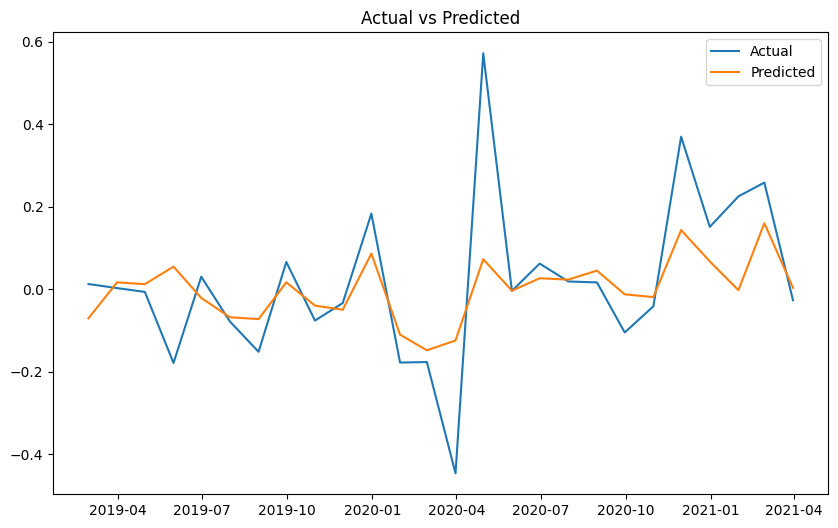

In [47]:
from cgi import test
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt

# Prepare the data for Linear Regression
X_train = df[top_10_corr_features]
y_train = df[target_columns]
X_test = test_df[top_10_corr_features]
y_test = test_df[target_columns]

# Initialize the Linear Regression model
model = LinearRegression()

# Fit the model with the training data
model.fit(X_train, y_train)

# Make predictions on the test data
predictions = model.predict(X_test)

# Convert back to percentage change
actual_predictions = pd.Series(np.array(predictions).flatten()).pct_change()[1:]#.shift(-1)
actual_y_test = test_df[returns_col]
actual_y_test = np.array(actual_y_test.values).flatten()[1:]

# Calculate RMSE
rmse = sqrt(mean_squared_error(y_test, predictions))
rmse = sqrt(mean_squared_error(actual_y_test, actual_predictions))
print(f'RMSE: {rmse}')



# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
# plt.plot([x[1] for x in y_test.index], y_test, label='Actual')
# plt.plot([x[1] for x in y_test.index], predictions, label='Predicted')

plt.plot([x[1] for x in y_test.index][1:], actual_y_test, label='Actual')
plt.plot([x[1] for x in y_test.index][1:], actual_predictions, label='Predicted')
plt.legend(loc='best')
plt.title('Actual vs Predicted')
plt.show()

<Axes: xlabel='simulated_portfolio_value', ylabel='CAPEI_Median'>

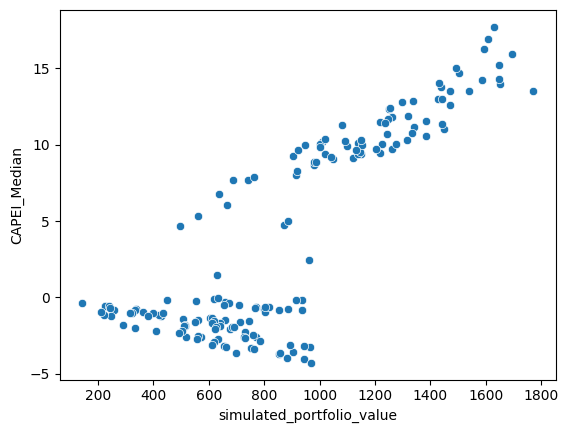

In [13]:
sns.scatterplot(data=df, x=target_columns[0], y='CAPEI_Median')

<Axes: xlabel='simulated_portfolio_value', ylabel='pe_exi_Median'>

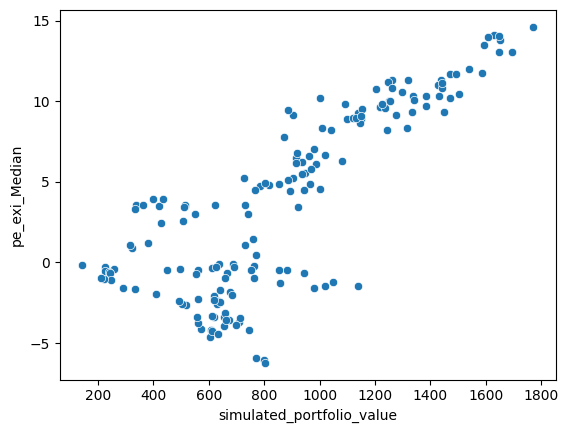

In [12]:
sns.scatterplot(data=df, x=target_columns[0], y='pe_exi_Median')

<Axes: xlabel='public_date', ylabel='simulated_portfolio_value'>

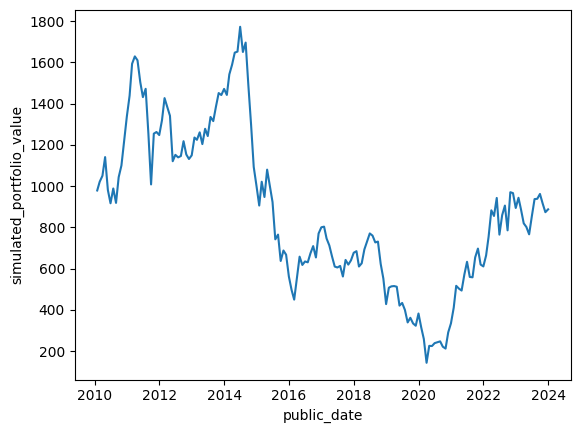

In [15]:
sns.lineplot(data=df, x=date_column, y=target_columns[0])

<Axes: xlabel='public_date', ylabel='ps_Median_EMA'>

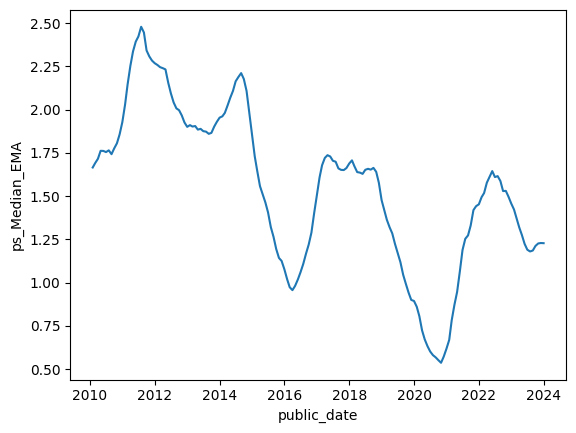

In [20]:
df['ps_Median_EMA'] = df['ps_Median'].ewm(span=12, adjust=False).mean()
sns.lineplot(data=df, x=date_column, y='ps_Median_EMA')

In [21]:
df.corr()

,NFIRM,indret_ew,indret_vw,PEG_1yrforward_Median,CAPEI_Median,bm_Median,PEG_ltgforward_Median,evm_Median,pe_op_basic_Median,pe_op_dil_Median,...,sale_invcap_Median,sale_nwc_Median,accrual_Median,rd_sale_Median,adv_sale_Median,staff_sale_Median,multiplicative_factor,cumulative_factor,simulated_portfolio_value,ps_Median_EMA
NFIRM,1.000000,-0.141749,-0.107347,-0.038136,0.792311,-0.207047,0.412529,0.468648,0.545576,0.536866,...,-0.547876,-0.146471,0.135504,NaN,NaN,NaN,-0.141749,0.548104,0.548104,0.638157
indret_ew,-0.141749,1.000000,0.930999,0.052449,-0.065932,0.105356,-0.001673,-0.136034,-0.061825,-0.057008,...,0.019714,-0.111231,-0.126818,NaN,NaN,NaN,1.000000,0.047963,0.047963,-0.097921
indret_vw,-0.107347,0.930999,1.000000,0.012818,-0.046200,-0.005320,0.070277,-0.084074,-0.022862,-0.018870,...,0.028000,-0.113563,-0.037809,NaN,NaN,NaN,0.930999,0.095331,0.095331,-0.015909
PEG_1yrforward_Median,-0.038136,0.052449,0.012818,1.000000,0.052965,-0.071814,0.276653,0.002668,0.175111,0.175869,...,0.210462,0.103946,0.169692,NaN,NaN,NaN,0.052449,0.163657,0.163657,0.123251
CAPEI_Median,0.792311,-0.065932,-0.046200,0.052965,1.000000,-0.292924,0.635669,0.165283,0.815837,0.809891,...,-0.249296,0.045673,0.204884,NaN,NaN,NaN,-0.065932,0.836579,0.836579,0.697455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
staff_sale_Median,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
multiplicative_factor,-0.141749,1.000000,0.930999,0.052449,-0.065932,0.105356,-0.001673,-0.136034,-0.061825,-0.057008,...,0.019714,-0.111231,-0.126818,NaN,NaN,NaN,1.000000,0.047963,0.047963,-0.097921
cumulative_factor,0.548104,0.047963,0.095331,0.163657,0.836579,-0.590316,0.750843,0.155402,0.806885,0.807557,...,0.008614,0.022122,0.453396,NaN,NaN,NaN,0.047963,1.000000,1.000000,0.863147
simulated_portfolio_value,0.548104,0.047963,0.095331,0.163657,0.836579,-0.590316,0.750843,0.155402,0.806885,0.807557,...,0.008614,0.022122,0.453396,NaN,NaN,NaN,0.047963,1.000000,1.000000,0.863147


In [ ]:
# corr_all = df.corr()['MCAP']
# corr_all['MCAP']#.abs()#.sort_values(by='MCAP', ascending=False)

1.0

In [ ]:
# df['ptb_Median_6M'].corr(df['indret_ew'])

-0.09706326778953976

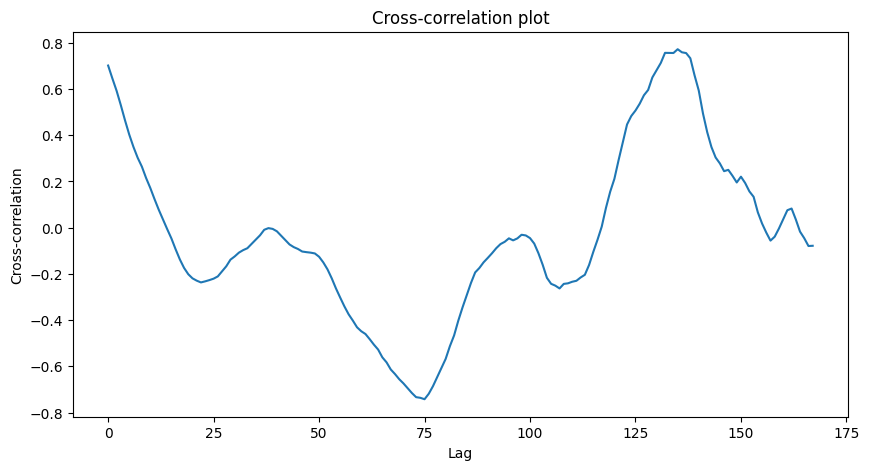

In [14]:
import statsmodels.tsa.stattools as stats

# Assuming df is your DataFrame and 'ptb_Median', 'target_columns' are the columns you want to find cross-correlation between
d1 = df['ptb_Median']
d2 = df[target_columns]

# Compute cross-correlations
xcov = stats.ccf(d1, d2)

# Plot the cross-correlation values
plt.figure(figsize=(10, 5))
plt.plot(range(len(xcov)), xcov)
plt.title('Cross-correlation plot')
plt.xlabel('Lag')
plt.ylabel('Cross-correlation')
plt.show()

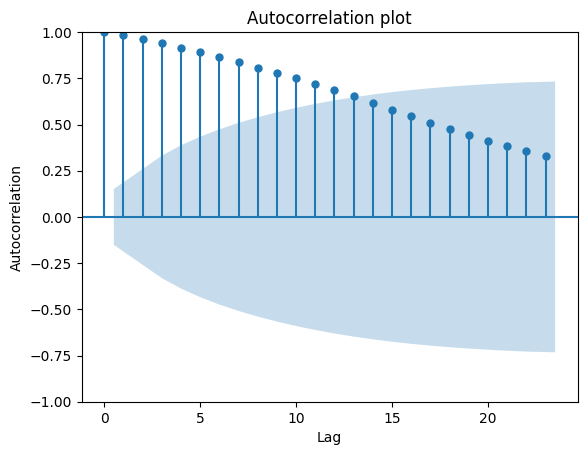

In [55]:
import statsmodels.graphics.tsaplots as tsaplots

# Assuming xcov is your cross-correlation values
tsaplots.plot_acf(xcov)
plt.title('Autocorrelation plot')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

In [89]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

def create_model(df, target_var, exclude_vars=[]):
    # Split remaining data
    X = df.drop(columns=[target_var] + exclude_vars)
    X = X.replace([np.inf, -np.inf], np.nan)
    X = X.fillna(X.mean())
    y = df[target_var]
    # Determine the split point
    split_point = int(len(X) * 0.8)

    # Split the data
    X_train, X_test = X[:split_point], X[split_point:]
    y_train, y_test = y[:split_point], y[split_point:]

    # Create and fit model
    model = LinearRegression()
    model.fit(X_train, y_train)

    return model, X_train, X_test, y_train, y_test, holdout

model, X_train, X_test, y_train, y_test, holdout = create_model(df, target_columns[0], exclude_vars=['cumulative_factor', 'multiplicative_factor'])

In [113]:
actual_y_test = pd.Series(df.loc[y_test.index]['indret_ew'].reset_index(drop=True))

In [114]:
predictions = model.predict(X_test)
predictions_series = pd.Series(predictions)

percentage_change = predictions_series.pct_change()

In [125]:
residuals = actual_y_test - percentage_change
SS_res = (residuals**2).sum()
SS_tot = ((actual_y_test - actual_y_test.mean())**2).sum()
r2_score = 1 - (SS_res / SS_tot)
r2_score

-0.5032965723800582

In [129]:
pd.DataFrame([percentage_change, actual_y_test]).T

,Unnamed 0,indret_ew
0,NaN,0.185707
1,0.654088,0.012803
2,-0.028614,0.002943
3,0.010621,-0.006342
4,-0.207436,-0.178626
5,0.048569,0.030526
6,0.031903,-0.078084
7,-0.141888,-0.151637
8,0.014431,0.066333
9,-0.077796,-0.075762


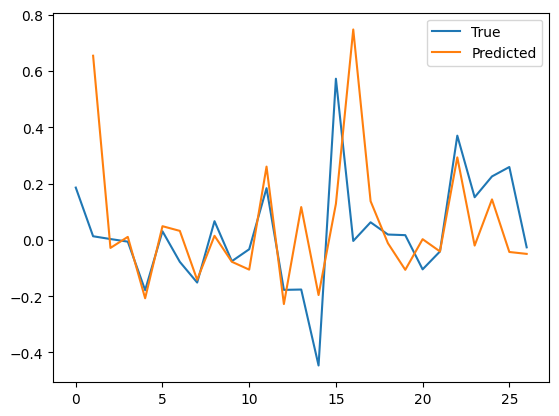

In [121]:
plt.plot(actual_y_test, label='True')
plt.plot(percentage_change, label='Predicted')
plt.legend()


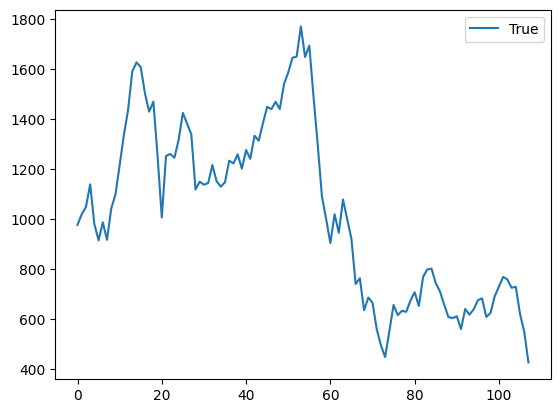

In [85]:
plt.plot(y_train.values, label='True')
# plt.plot(X_train.values, label='Predicted')
plt.legend()


<Axes: xlabel='coefficient', ylabel='feature'>

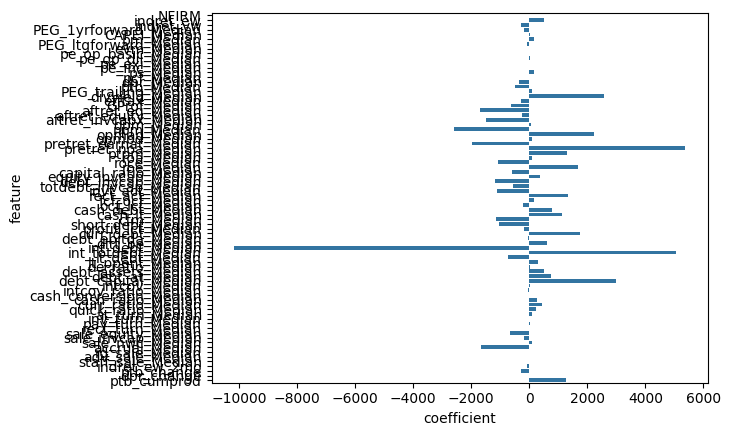

In [77]:
feature_names = X_train.columns
coef_df = pd.DataFrame({'feature': feature_names, 'coefficient': model.coef_})

sns.barplot(data=coef_df, x='coefficient', y='feature')

In [73]:
X_test

NFIRM  indret_ew  indret_vw  PEG_1yrforward_Median  \
gicdesc public_date                                                       
Energy  2019-01-31     201   0.185707   0.112002                 -0.002   
        2019-02-28     199   0.012803   0.021442                 -0.010   
        2019-03-31     197   0.002943   0.023966                 -0.073   
        2019-04-30     198  -0.006342  -0.000341                 -0.076   
        2019-05-31     198  -0.178626  -0.113337                 -0.107   
        2019-06-30     199   0.030526   0.083221                 -0.119   
        2019-07-31     197  -0.078084  -0.028016                 -0.116   
        2019-08-31     194  -0.151637  -0.084708                 -0.060   
        2019-09-30     194   0.066333   0.038414                 -0.055   
        2019-10-31     192  -0.075762  -0.023971                 -0.062   
        2019-11-30     190  -0.033361   0.007177                 -0.084   
        2019-12-31     185   0.183690   0.068752                 -0.084   
        2020-01-31     182  -0.177621  -0.115271                 -0.066   
        2020-02-29     182  -0.176400  -0.147811                 -0.028   
        2020-03-31     182  -0.446190  -0.357023                 -0.042   
        2020-04-30     180   0.572473   0.325330                 -0.047   
        2020-05-31     179  -0.003855   0.012125                 -0.042   
        2020-06-30     178   0.062448  -0.006970                 -0.041   
        2020-07-31     176   0.018969  -0.043884                 -0.039   
        2020-08-31     170   0.016741  -0.005088                 -0.034   
        2020-09-30     166  -0.104702  -0.139969                 -0.028   
        2020-10-31     165  -0.041239  -0.039862                 -0.027   
        2020-11-30     164   0.370223   0.273211                 -0.029   
        2020-12-31     162   0.151443   0.054493                 -0.030   
        2021-01-31     158   0.225419   0.047930                 -0.030   
        2021-02-28     158   0.258849   0.220263                 -0.041   
        2021-03-31     157  -0.026515   0.031619                 -0.035   

                     CAPEI_Median  bm_Median  PEG_ltgforward_Median  \
gicdesc public_date                                                   
Energy  2019-01-31         -1.439      0.695                  0.219   
        2019-02-28         -1.783      1.017                  0.238   
        2019-03-31         -1.895      1.021                  0.393   
        2019-04-30         -1.853      1.017                  0.359   
        2019-05-31         -1.136      0.878                  0.544   
        2019-06-30         -0.988      0.873                  0.544   
        2019-07-31         -1.012      0.873                  0.391   
        2019-08-31         -0.731      0.905                  0.342   
        2019-09-30         -0.960      0.906                  0.311   
        2019-10-31         -0.798      0.906                 -0.013   
        2019-11-30         -1.005      1.090                 -0.089   
        2019-12-31         -1.200      1.091                 -0.124   
        2020-01-31         -0.990      1.055                 -0.142   
        2020-02-29         -0.811      0.971                 -0.029   
        2020-03-31         -0.357      0.956                 -0.014   
        2020-04-30         -0.561      0.956                 -0.066   
        2020-05-31         -0.586      1.945                 -0.109   
        2020-06-30         -0.582      1.939                 -0.086   
        2020-07-31         -0.667      1.918                 -0.075   
        2020-08-31         -1.222      1.261                 -0.188   
        2020-09-30         -1.153      1.212                 -0.259   
        2020-10-31         -0.969      1.211                 -0.293   
        2020-11-30         -1.811      1.346                 -0.245   
        2020-12-31         -1.985      1.327                 -0.311   

In [78]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test, model.predict(X_test))


267452.5040549259

# Percentage based approach


In [27]:
# lagged_2mo_col = returns_col + '_2mo'
# df[lagged_2mo_col] = df[returns_col].shift(8)

In [26]:
# df['ptb_change'] = df['ptb_Median'].pct_change()
# df['dpr_change'] = df['dpr_Median'].pct_change()
# df['ptb_cumprod'] = (1 + df['ptb_change']).cumprod()
# df.corr()[lagged_2mo_col].drop(lagged_2mo_col).abs().sort_values(ascending=False)

ptb_Median               0.230002
ptb_cumprod              0.230002
lt_ppent_Median          0.186351
pcf_Median               0.178296
fcf_ocf_Median           0.172087
                           ...   
aftret_invcapx_Median    0.002780
debt_capital_Median      0.002523
rd_sale_Median                NaN
adv_sale_Median               NaN
staff_sale_Median             NaN
Name: indret_ew_2mo, Length: 77, dtype: float64

In [ ]:
# corr_all = df.corr()[target_columns].drop(target_columns + ['cumulative_factor', 'multiplicative_factor'], errors='ignore')
# corr_all[target_columns].abs().sort_values(by=target_columns, ascending=False).head(20)

,simulated_portfolio_value
CAPEI_Median,0.832927
pe_exi_Median,0.801650
pe_op_basic_Median,0.792608
pe_op_dil_Median,0.791563
pe_inc_Median,0.786825
PEG_trailing_Median,0.778165
pay_turn_Median,0.730859
gpm_Median,0.705802
opmbd_Median,0.697379
NFIRM,0.692305
